# Process EK80 WF data through subsampling
Drawn loosely from the [echopype-examples](https://github.com/OSOceanAcoustics/echopype-examples) notebook "[Ship's track](https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/ship_tracks.ipynb)."

## Imports

In [126]:
from pathlib import Path

import xarray as xr
import numpy as np
import glob

import matplotlib.pyplot as plt

import echopype as ep
from echopype.qc import exist_reversed_time

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)

## Set up paths

In [33]:
# Path to the root data directory:
data_path = Path("/home/tkeffer/Data/WesternFlyerData/Echosounder_EK80Portable/Leg 3/")

echodata_zarr_path = data_path / "echodata_zarr"
Sv_zarr_path = data_path / "Sv_zarr"
Sv_zarr_path.mkdir(exist_ok=True)
MVBS_zarr_path = data_path / "MVBS_zarr"
MVBS_zarr_path.mkdir(exist_ok=True)

## Calculate Sv
For each zarr files, calculate Sv, then save to disk

In [139]:
%%time

zarr_files = echodata_zarr_path.glob("*.zarr")

for zf in zarr_files:
    zarr_fpath = Path(zf)
    ed_zarr = ep.open_converted(zf)

    # Calibrate backscatter measurement to Sv 
    ds_Sv = ep.calibrate.compute_Sv(ed_zarr, waveform_mode="CW", encode_mode="complex")

    # Add depth to the Sv dataset
    ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=1)

    # Save Sv dataset to Zarr on disk
    ds_Sv.to_zarr(Sv_zarr_path / f"{zarr_fpath.stem}_Sv.zarr", mode="w")

Done
CPU times: user 48.2 s, sys: 14.9 s, total: 1min 3s
Wall time: 43.7 s


# Subsample
Subsample into 5-second and 0.5m bins

Note that a 5-second bin may span a file boundary. For this reason, if we don't have the whole time interval when we reach the end of a file, save what's left over and use it with the next file.

In [140]:
%%time

# Grab and sort Sv zarr paths
Sv_zarr_path_list = list(Sv_zarr_path.glob('*.zarr'))
Sv_zarr_path_list.sort()

# Initialize leftover ds_Sv zarr as None
leftover_ds_Sv = None

# Iterate through all Sv Zarr Paths
for file_path in Sv_zarr_path_list:

    # Open ds_Sv from disk Zarr
    ds_Sv = xr.open_zarr(file_path)

    # Concat leftover Sv with current Sv
    if leftover_ds_Sv is not None:
        concat_ds_Sv = xr.concat([leftover_ds_Sv, ds_Sv], dim="ping_time")
    else:
        concat_ds_Sv = ds_Sv
    
    # Resample data into 5-second bins
    resampled_data = concat_ds_Sv.resample(ping_time="20s", skipna=True)

    # Determine the start index of the last incomplete 20-second bin
    cutoff_index = max(group.start for group in resampled_data.groups.values())

    # Split data into complete and incomplete bins:

    # Take data up to the last complete bin
    complete_bins_Sv = concat_ds_Sv.isel(ping_time=slice(0, cutoff_index))

    # Keep remaining data for next iteration
    leftover_bin_Sv = concat_ds_Sv.isel(ping_time=slice(cutoff_index, -1))

    # Compute MVBS on current subset
    ds_MVBS = ep.commongrid.compute_MVBS(
        complete_bins_Sv,
        range_var="depth",
        range_bin='0.5m',  # in meters
        ping_time_bin='5s',  # in seconds
    )

    # Save MVBS dataset to Zarr on disk
    ds_MVBS.to_zarr(MVBS_zarr_path / f"{file_path.stem.replace('Sv', 'MVBS')}.zarr", mode="w")

CPU times: user 19.4 s, sys: 1.07 s, total: 20.5 s
Wall time: 27.8 s


## Unique ping times
Check that each ping time is unique across all MVBS Zarr stores

In [141]:
%%time

# Iterate through MVBS Zarr Stores
for file_path in MVBS_zarr_path.glob('*.zarr'):

    # Grab ping times from MVBS Zarr Store
    ping_times = xr.open_zarr(file_path)["ping_time"].values

    # Check that all ping times are unique
    assert len(np.unique(ping_times)) == len(ping_times)

CPU times: user 55.3 ms, sys: 6.13 ms, total: 61.5 ms
Wall time: 58 ms


#### Test for time reversals

Small time reversals are sometimes found in echosounder datasets, where some `ping_time` (or GPS `time1`) value may be lower (older) than the preceding `ping_time`. Such discontinuities can interfere with concatenating data from individual files to produce an aggregated dataset. This issues can be identified and addressed by functions in the `echopype.qc` subpackage.

In [109]:
for filepath in echodata_zarr_path.glob('*.zarr'):
    ed = ep.open_converted(filepath)
    # Test for a negative ping_time increment in sequential timestamps, in the Sonar/Beam_group1 group
    if exist_reversed_time(ds=ed['Sonar/Beam_group1'], time_name='ping_time'):
        print(f'Reversed time in {filepath}')

All seems to be OK.

#### Read all MVBS Zarr stores as a single dataset

Here we use the Xarray `open_mfdataset` function again to read all MVBS Zarr stores as a single dataset:

In [143]:
%%time
ds_MVBS = xr.open_mfdataset(
    str(MVBS_zarr_path / '*_MVBS.zarr'), 
    data_vars='minimal', coords='minimal',
    combine='by_coords',
    engine="zarr",
)

CPU times: user 313 ms, sys: 20.5 ms, total: 334 ms
Wall time: 472 ms


Replace the `channel` dimension and coordinate with the `frequency_nominal` variable containing actual frequency values. Note that this step is possible only because there are no duplicated frequencies present.

In [144]:
ds_MVBS = ep.consolidate.swap_dims_channel_frequency(ds_MVBS)
ds_MVBS

<xarray.Dataset> Size: 1MB
Dimensions:            (frequency_nominal: 2, ping_time: 166, depth: 453)
Coordinates:
  * frequency_nominal  (frequency_nominal) float64 16B 3.8e+04 2e+05
  * depth              (depth) float64 4kB 0.0 0.5 1.0 1.5 ... 225.0 225.5 226.0
  * ping_time          (ping_time) datetime64[ns] 1kB 2025-04-16T19:12:30 ......
Data variables:
    Sv                 (frequency_nominal, ping_time, depth) float64 1MB dask.array<chunksize=(2, 14, 253), meta=np.ndarray>
    channel            (frequency_nominal) <U36 288B 'WBT Mini 278014-7 ES38-...
Attributes:
    processing_function:          commongrid.compute_MVBS
    processing_software_name:     echopype
    processing_software_version:  0.10.1
    processing_time:              2025-09-14T20:51:48Z

In [145]:
ds_MVBS["Sv"]

<xarray.DataArray 'Sv' (frequency_nominal: 2, ping_time: 166, depth: 453)> Size: 1MB
dask.array<concatenate, shape=(2, 166, 453), dtype=float64, chunksize=(2, 15, 253), chunktype=numpy.ndarray>
Coordinates:
  * frequency_nominal  (frequency_nominal) float64 16B 3.8e+04 2e+05
  * depth              (depth) float64 4kB 0.0 0.5 1.0 1.5 ... 225.0 225.5 226.0
  * ping_time          (ping_time) datetime64[ns] 1kB 2025-04-16T19:12:30 ......
Attributes:
    binning_mode:          physical units
    cell_methods:          ping_time: mean (interval: 5 second comment: ping_...
    long_name:             Mean volume backscattering strength (MVBS, mean Sv...
    ping_time_interval:    5s
    range_meter_interval:  0.5m
    units:                 dB

## Plot

Text(0.5, 1.0, '38 kHz')

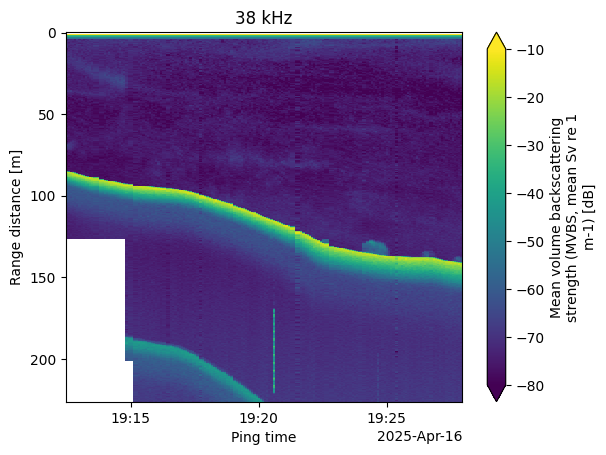

In [138]:
(
    ds_MVBS["Sv"]
    .isel(frequency_nominal=0)    # Select a channel. Channel 0 is 38k
    .plot(x='ping_time',y='depth',yincrease=False,vmin=-80,vmax=-10)
)
plt.title("38 kHz")


Text(0.5, 1.0, '200 kHz')

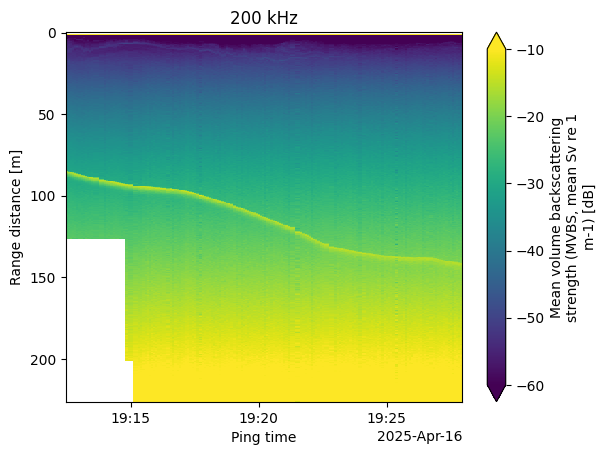

In [153]:
(
    ds_MVBS["Sv"]
    .isel(frequency_nominal=1)    # Select a channel. Channel 0 is 200k
    .plot(x='ping_time',y='depth',yincrease=False,vmin=-60,vmax=-10)
)
plt.title("200 kHz")


In [116]:
type(ds_MVBS["Sv"]

xarray.core.dataarray.DataArray